# Image Classification: beyond simple CNNs

## Introduction

In the field of computer vision, especially in image recognition and classification, Convolutional Neural Networks (CNN) are second to none. 

## Aim

Aim of this project is to compare several CNN architectures in terrm of their speed and accuracy.

## Method

The models were trained in 100 epochs with SGD optimizer and a learning rate that was cosine-annealed to zero in the training process. The objective loss function was cross-entropy. Th emodels were train on a GPU (dedicated graphic card) using the NVIDIA CUDA backend.

Models implementations were copied from [here](https://github.com/kuangliu/pytorch-cifar/) and the whole training process was performed in the train_test_net.py script. In the script the appropriate functions which are showcased in this notebook are defined and actually used.

Then the obtained nets were compared on the validation datasets and the results were presented. 

### Models used

#### ResNet

Residual Networks constitute a true breakthrough in computer vision. It's use allowed to train networks that were deeper than ever before.
Before ResNets, increasing accuracy of a network could pretty much be achieved only through stacking additional convolutional blocks over one another.
The increased accurasy came at huge cost of training time and often faced the vanishing-gradient problem. The vanishing gradient problem is an issue that occurs when, in a deep network, the back propagation causes the gradient of the objective finctions to become zero (vanish) which prevents the signal to be propagated to the feature layers at the beginning of chain of layers. 

A simple but genious solution was to use the so called skip link (or identity connection) depicted below.


![image.png](https://miro.medium.com/max/608/1*_T6ybgHUoxj8rJq_Dc1nsw.jpeg)

The main point of introducing this link is that, instead of expecting the stacked layers to learn the approximate the function H(x), which we do in normal stacked convolutional neural network, we let the layers to approximate the residual function $F(x) = H(x) - x$

This approach solves the vanishing-gradient problem i.e. even if $H(x)$ becomes zero, the network will atleast learn $x$ (since $F(x) = H(x) — x$) i.e. it saves the gradients from vanishing. As a result of this, the gradients reach the input layers and the weights are updated which helps the network to learn better and hence accuracy of the network increases.

The chart below depicts a typical ResNet architecture. In the project two ResNets with 18 and 50 layers were trained.

![img.png](https://www.researchgate.net/publication/336642248/figure/fig1/AS:839151377203201@1577080687133/Original-ResNet-18-Architecture.png)



#### DenseNet
**Dense Convolutional Network (DenseNet)**, connects each layer to every other layer in a feed-forward fashion. Whereas traditional convolutional networks with L layers have L connections - one between each layer and its subsequent layer - this network has L(L+1)/2 direct connections. For each layer, the feature-maps of all preceding layers are used as inputs, and its own feature-maps are used as inputs into all subsequent layers. DenseNets have several compelling advantages: they alleviate the vanishing-gradient problem, strengthen feature propagation, encourage feature reuse, and substantially reduce the number of parameters.

![image.png](https://pytorch.org/assets/images/densenet1.png)
#### GoogleNet

The crux of this architecture is the so called inception module. As authors in the original paper rwite, it was inspired by the Hebbian principle from human learning which says that “neurons that fire together, wire together”. It essentialy boils down to using many convolitional windows of different sizes whose outputs are later concatenated into one vector instead of just one concolutional layer. In this way the network can learn not only apropriate weight in the convolution layer but also the appropriate size of the filter. The layer may simply "switch off" a given size of the filter by setting the corresponding weight to 0. 
![img.png](https://pytorch.org/assets/images/googlenet1.png)


To see why this is usefull suppose, for example, a layer in our deep learning model has learned to focus on individual parts of a face. The next layer of the network would probably focus on the overall face in the image to identify the different objects present there. Now to actually do this, the layer should have the appropriate filter sizes to detect different objects.

This is where the inception layer comes to the fore. It allows the internal layers to pick and choose which filter size will be relevant to learn the required information. So even if the size of the face in the image is different, the layer works accordingly to recognize the face.

Below a GoogleNett architecture is shown.

![img.png](https://pytorch.org/assets/images/googlenet2.png)


#### MobileNet

In MobileNets the architecture rests on the idea of depthwise separable convolution. Generally separable convolution means using properties of matrices to decompose a convolution filter as a product of lower-dimension matrices or vectors. This allows to reduce the number of parameters to train as well as the number of multiplications and additions in the training process.

Example of filter separation of Sobel filter used to detect edges is shown below:

![img.png](https://miro.medium.com/max/1400/1*r4MjVvb2rehlIzpTKZdhcA.png)

The depthwise separable convolution is a depthwise convolution followed by a pointwise convolution. Depthwise means that we scan the image separately in each of the channels. For instance, in an RGB image, we would have 3 convolutions of each kind. The pointwise convolution is used to retirieve the original image so it is actually of dimension 1x1xD, where D is the number of channels (D=3 in the RGB example).

This idea allows MobileNets to be really fast and lightweight with relatively little sacrifice in terms of accuracy.

![img.png](https://miro.medium.com/max/1400/1*Voah8cvrs7gnTDf6acRvDw.png)

#### ResNext

The ResNeXt architecture is an extension of the deep residual network which replaces the standard residual block with one that leverages a "split-transform-merge" strategy (ie. branched paths within a cell) used in the Inception models. Simply, rather than performing convolutions over the full input feature map, the block's input is projected into a series of lower (channel) dimensional representations of which we separately apply a few convolutional filters before merging the results. In other words, with comparison to Inception module, the ResNext module splits the input by applying channel-wise convolution rather then differentiaion the sizes of the filters as it occurs in case of GoogleNet. 

The ResNeXt architecture simply mimicks the ResNet models, replacing the ResNet blocks for the ResNeXt block which is shown below.

![img.png](https://www.jeremyjordan.me/content/images/2018/04/Screen-Shot-2018-04-19-at-12.08.53-AM.png)

#### VGG
**VGG** stands for Visual Geometry Group at Oxford University because its creators are associated with this institution. 
This architecture consists if 16 weight layers (13 Convolution layers and 3 Fully Connected layers) with only 3x3 feature detectors or filters. The idea behind VGG net is that, as the depth of the network increases, we would increase the number of feature maps (the convolutions). In short, as we go deeper into the network, the number of feature maps increases, so the network becomes wider. This is actually the "oldest" architecture trained in this project.

![image.png](https://miro.medium.com/max/1400/1*_Lg1i7wv1pLpzp2F4MLrvw.png)



### Training procedure

In this section the training procedure along with the appropriate functions are briefly outlined.

In [6]:
import torch
from glob import glob
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from models import *

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import os
import argparse

from models import *
from utils import progress_bar

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 12]

#### Dataloaders

The cell below presents PyTorch Dataloaders that were used. The Dataloaders simply feed the specified data to the neural net and preprocess it on the fly using predefined transformers.

The *train transformations* were standard cropping , horizontal random flip (which reduces overfitting), transforming image to tensor, normalization of the channels and shuffling.

The *test transformations* were simply transformation to tensor and normalization. 

In [ ]:
 cinic_mean_RGB = (0.47889522, 0.47227842, 0.43047404)
    cinic_std_RGB = (0.24205776, 0.23828046, 0.25874835)

    # define transformations
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(cinic_mean_RGB, cinic_std_RGB),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cinic_mean_RGB, cinic_std_RGB),
    ])

    # define datasets
    trainset = datasets.ImageFolder(cinic_directory + '/train',transform=transform_train)
    testset = datasets.ImageFolder(cinic_directory + '/test',transform=transform_test)

    # define DataLoaders
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=64, shuffle=True, num_workers=2)

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=64, shuffle=False, num_workers=2)


Train and test functions are standard ones and can be viewed in the training script. The best accuracy was updated whenever accuracy achieved within epoch was higher than the currently best value. In such case, the model and the value were saved in an apropriate checkpoint. For each net, the training time was measured.

## Summary of results

### Loading the models

In [7]:
trained_models_pth = '../scripts/'
all_dirs = glob(trained_models_pth+'*/', recursive = True)
model_names = [di[di.find('int_')+4:-1] for di in all_dirs if di.find('int_') > 0 and di[di.find('int_')+4:-1] != 'dpn']
model_dirs = [trained_models_pth+'checkpoint_'+name for name in model_names]
model_dirs

['../scripts/checkpoint_densenet121',
 '../scripts/checkpoint_googlenet',
 '../scripts/checkpoint_mobilenet',
 '../scripts/checkpoint_ResNet',
 '../scripts/checkpoint_resnet50',
 '../scripts/checkpoint_resnext',
 '../scripts/checkpoint_vgg']

### Getting the best training scores on the test set

In [8]:
def get_acc_scores(model_dirs, model_names):
    scores = {}
    for model, model_dir in zip(model_names,model_dirs):
        ckp = torch.load(model_dir+'/ckpt.pth')
        scores[model] = ckp['acc']
        
    return(scores)
train_scores = get_acc_scores(model_dirs,model_names)

In [9]:
train_scores

{'densenet121': 73.46555555555555,
 'googlenet': 69.50666666666666,
 'mobilenet': 58.163333333333334,
 'ResNet': 74.73555555555555,
 'resnet50': 72.33,
 'resnext': 73.31222222222222,
 'vgg': 67.21222222222222}

### Getting scores on validation dataset

In [10]:
cinic_mean_RGB = (0.47889522, 0.47227842, 0.43047404)
cinic_std_RGB = (0.24205776, 0.23828046, 0.25874835)

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cinic_mean_RGB, cinic_std_RGB),
])

cinic_directory = "../data"


valset = datasets.ImageFolder(cinic_directory + '/valid',transform=transform_val)

valloader = torch.utils.data.DataLoader(
    valset, batch_size=64, shuffle=False, num_workers=2)

In [11]:
def validate_net(net):
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if device == 'cuda':
        torch.cuda.empty_cache()
        net = torch.nn.DataParallel(net)
        cudnn.benchmark = True
    
    criterion = nn.CrossEntropyLoss()
#     optimizer = optim.SGD(net.parameters(), lr=args.lr,
#                           momentum=0.9, weight_decay=5e-4)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
    
    net = net.to(device)
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(valloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    return(100.*correct/total)

In [12]:
nets=[DenseNet121(),GoogLeNet(),MobileNet(),ResNet18(),ResNet50(),ResNeXt29_2x64d(),VGG('VGG19')]

In [ ]:
val_scores = {}
for net, model_name, model_dir in zip(nets,model_names,model_dirs):
    print(f"Loading model {model_name} from {model_dir}...")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if device == 'cuda':
        torch.cuda.empty_cache()
        net = torch.nn.DataParallel(net)
        cudnn.benchmark = True
    checkpoint = torch.load(model_dir+'/ckpt.pth')
    #checkpoint['net']
    # net.load_state_dict(checkpoint['net'])
    net.load_state_dict(checkpoint['net'])
    val_scores[model_name] = validate_net(net)

### Getting the training times from the saved textfiles

In [14]:
time_scores = {model_name:0 for model_name in model_names}
time_scores['densenet121'] = 39697
time_scores['googlenet'] = 40200
time_scores['mobilenet'] = 15914
time_scores['ResNet'] = 13822
time_scores['resnet50'] = 41158
time_scores['resnext'] = 36990
time_scores['vgg'] = 14470

time_scores

{'densenet121': 39697,
 'googlenet': 40200,
 'mobilenet': 15914,
 'ResNet': 13822,
 'resnet50': 41158,
 'resnext': 36990,
 'vgg': 14470}

### Visualizing the results

In [15]:
df_dict = {'name':model_names, 
           'time':list(time_scores.values()),
           'train_score' : list(train_scores.values()),
           'val_score' : list(val_scores.values())}
df = pd.DataFrame(df_dict)
df['time'] = df['time']/3600
df.to_csv('fin_df.csv')

In [16]:

plt.rcParams['figure.figsize'] = [8, 5]

### Validation scores

<AxesSubplot:xlabel='name'>

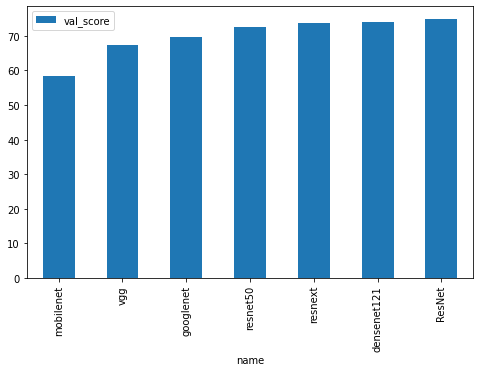

In [21]:
df.sort_values('val_score').plot.bar(x='name',y='val_score')


### Training time plot  

<AxesSubplot:xlabel='name'>

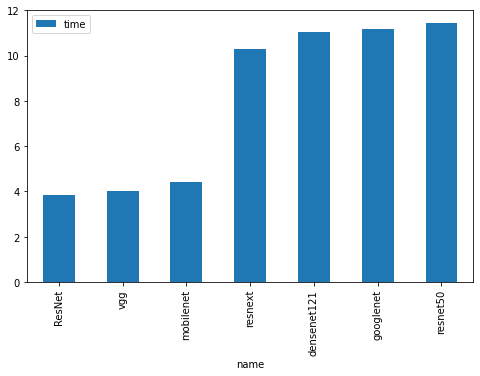

In [22]:
df.sort_values('time').plot.bar(x='name',y='time')

### Time vs. validation score plot

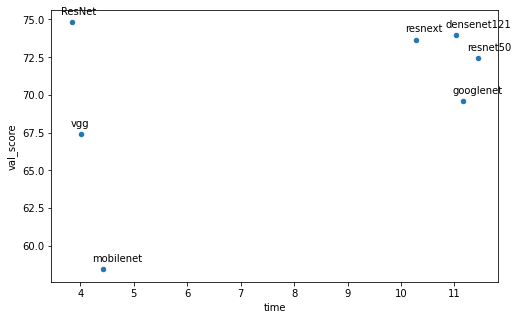

In [19]:
ax = df.sort_values('time').plot.scatter(x='time',y='val_score')
for i, txt in enumerate(df['name']):
    ax.annotate(txt, (df['time'][i]-0.2, df['val_score'][i]+0.5))

### Test vs. validation score plot

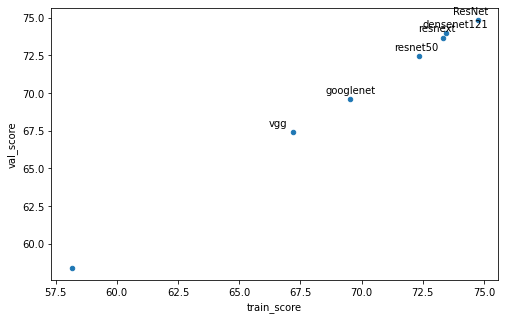

In [29]:
ax = df.sort_values('time').plot.scatter(x='train_score',y='val_score')
for i, txt in enumerate(df['name']):
    ax.annotate(txt, (df['train_score'][i]-1, df['val_score'][i]+0.4))

### Conclusions

We can see that the ResNet architecture was both the fastest to train and the most accurate at the same time. This is a very interesting result, takining into account that it was not the most complicated nor the newest architecture. It is also very interesting to see that The 18-layer version was more accurate on the validation score which indicates the tendency of bigger networks to overfit on simple tasks such as the one in this project.

Another interesting observation is that very modern, complicated architectures which took very long to train, were only roughly 5% better in terms of accuracy when compared to the old VGG architecture. This shows that for such (relatively) simple tasks as image classification, the older architectures are still offering good accuracy. 

When comparing the test vs validation scores wee can see that all the networks present vary good generalizability and that none of them suffered from substantial overfitting.

When it comes to the definite looser of this competition, that is the MobileNet, the result could be anticipated. This net was actually designet to be slightly worse than the more computation-heavy equivalents and its primary goal is to be used as a object recognition/detection backend on small devices such as mobile phones

## References

* PyTorch documentation
* https://medium.com/analytics-vidhya/deep-residual-learning-for-image-recognition-resnet-94a9c71334c9
* https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/
* https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728
* https://medium.com/analytics-vidhya/image-classification-with-mobilenet-cc6fbb2cd470
* https://www.jeremyjordan.me/convnet-architectures/
* https://github.com/kuangliu/pytorch-cifar/